Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


In [1]:
import json
import re
import warnings
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import sklearn as sk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

nltk.download("stopwords")
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/dqmis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
# download sentiment lexicon
!curl -o sent_lexicon https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!curl -o reviews.json https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  647k  100  647k    0     0  1716k      0 --:--:-- --:--:-- --:--:-- 1725k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0 79.6M    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  3 79.6M    3 2914k    0     0   815k      0  0:01:40  0:00:03  0:01:37  815k
 14 79.6M   14 11.5M    0     0  2588k      0  0:00:31  0:00:04  0:00:27 2588k
 23 79.6M   23 18.8M    0     0  3466k      0  0:0

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [2]:
def accuracy_score(y_true: List[int], y_pred: List[int]) -> float:
    """Compute accuracy score."""

    return sum([1 if y_true[i] == y_pred[i] else 0 for i in range(len(y_true))]) / len(
        y_true
    )

In [4]:
@dataclass
class Sample:
    value: List[str]
    label: int
    pos: List[str]
    cv_idx: int


class Dataset:
    def __init__(
        self, reviews: List[Dict[str, Any]], pos_to_keep: Optional[List[str]] = None
    ) -> None:
        self._samples: List[Sample] = self._construct_dataset(
            reviews, pos_to_keep or []
        )

    def _construct_dataset(
        self, reviews: List[Dict[str, Any]], pos_to_keep
    ) -> List[Sample]:
        samples: List[Sample] = []

        for review in reviews:
            content: List[str] = []
            pos: List[str] = []
            for line in review["content"]:
                for word in line:
                    if len(pos_to_keep) > 0 and word[1] not in pos_to_keep:
                        continue
                    content.append(word[0])
                    pos.append(word[1])

            label = int(review["sentiment"] == "POS")
            cv_idx = review["cv"]

            samples.append(Sample(content, label, pos, cv_idx))
        return samples

    def train_test_split(
        self, validation_idx: Tuple[int, int], add_pos: bool = False
    ) -> Tuple[List[str], List[int], List[str], List[int]]:
        train_x, train_y, validation_x, validation_y = [], [], [], []

        for sample in self._samples:
            sentence = (
                [word + "-" + pos for word, pos in zip(sample.value, sample.pos)]
                if add_pos
                else sample.value
            )
            if validation_idx[0] <= sample.cv_idx < validation_idx[1]:
                validation_x.append(" ".join(sentence))
                validation_y.append(sample.label)
            else:
                train_x.append(" ".join(sentence))
                train_y.append(sample.label)

        return train_x, train_y, validation_x, validation_y

In [ ]:
with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

In [ ]:
dataset = Dataset(reviews)

train_x, train_y, test_x, test_y = dataset.train_test_split((900, 1000))

# (1) Lexicon-based approach (3.5pts)

A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [6]:
# Getting full dataset

X, Y, _, _ = dataset.train_test_split((-1, -1))

In [7]:
class LexiconPredictor:
    def __init__(self):
        self._sent_lexicon = self._create_lexicon()

    def _create_lexicon(self, path: str = "sent_lexicon") -> Dict[str, Dict[str, str]]:
        lexi = {}
        with open("sent_lexicon", mode="r", encoding="utf-8") as f:
            for line in f:
                ln = line.strip().split()
                word = ln[2].split("=")[1]
                if word in lexi:
                    lexi[word].append(
                        {
                            parts[0]: parts[1]
                            for line in ln
                            if (parts := line.split("="))[0] != "word1"
                        }
                    )
                else:
                    lexi[word] = [
                        {
                            parts[0]: parts[1]
                            for line in ln
                            if (parts := line.split("="))[0] != "word1"
                        }
                    ]
        return lexi

    def predict(self, sentence: str, threshold: float = 0.8) -> bool:
        score = 0
        for word in sentence.split():
            lexicon = self._sent_lexicon.get(word.lower())
            if lexicon:
                for lex in lexicon:
                    if lex["priorpolarity"] == "positive":
                        score += 1
                    elif lex["priorpolarity"] == "negative":
                        score -= 1
        return score > threshold


model = LexiconPredictor()

token_results = [model.predict(x, threshold=8) for x in X]
token_accuracy = sum(
    [1 if token_results[i] == Y[i] else 0 for i in range(len(token_results))]
) / len(token_results)

print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.63


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [21]:
# YOUR CODE HERE


class LexiconPredictorWithWeight(LexiconPredictor):
    def __init__(
        self, strong_token_weight: float = 1.0, weak_token_weight: float = 0.5
    ):
        self._sent_lexicon = self._create_lexicon()
        self._strong_token_weight = strong_token_weight
        self._weak_token_weight = weak_token_weight

    def predict(self, sentence: str, threshold: float = 0.8) -> bool:
        score = 0
        for word in sentence.split():
            lexicon = self._sent_lexicon.get(word.lower())
            if lexicon:
                for lex in lexicon:
                    weight = (
                        self._strong_token_weight
                        if lex["type"] == "strongsubj"
                        else self._weak_token_weight
                    )
                    if lex["priorpolarity"] == "positive":
                        score += 1 * weight
                    elif lex["priorpolarity"] == "negative":
                        score -= 1 * weight

        return score > threshold

In [22]:
best_threshold = 0
best_accuracy = 0
best_strong_weight = 0
best_weak_weight = 0

for strong_weight in np.arange(0.3, 1.1, 0.1):
    for weak_weight in np.arange(0.1, 0.8, 0.1):
        model = LexiconPredictorWithWeight(
            strong_token_weight=strong_weight, weak_token_weight=weak_weight
        )
        for threshold in range(0, 10):
            token_results = [model.predict(x, threshold=threshold) for x in X]
            token_accuracy = sum(
                [
                    1 if token_results[i] == Y[i] else 0
                    for i in range(len(token_results))
                ]
            ) / len(token_results)
            if token_accuracy > best_accuracy:
                best_accuracy = token_accuracy
                best_threshold = threshold
                best_strong_weight = strong_weight
                best_weak_weight = weak_weight

model = LexiconPredictorWithWeight(
    strong_token_weight=best_strong_weight, weak_token_weight=best_weak_weight
)
magnitude_results = [model.predict(x, threshold=best_threshold) for x in X]
magnitude_accuracy = sum(
    [1 if token_results[i] == Y[i] else 0 for i in range(len(token_results))]
) / len(token_results)

print("Accuracy: %0.2f" % magnitude_accuracy)
print("Best threshold: %0.2f" % best_threshold)
print("Best strong weight: %0.2f" % best_strong_weight)
print("Best weak weight: %0.2f" % best_weak_weight)

Accuracy: 0.64
Best threshold: 8.00
Best strong weight: 0.80
Best weak weight: 0.30


#### (Q.1.3) Make a barplot of the two results (0.5pt)

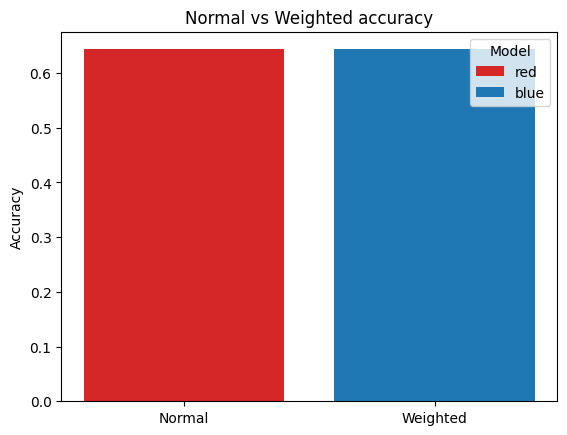

In [23]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

names = ["Normal", "Weighted"]
counts = [token_accuracy, magnitude_accuracy]
bar_labels = ["red", "blue"]
bar_colors = ["tab:red", "tab:blue"]

ax.bar(names, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel("Accuracy")
ax.set_title("Normal vs Weighted accuracy")
ax.legend(title="Model")

plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

In [13]:
# YOUR CODE HERE

# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

*Write your answer here.*

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999. Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [52]:
def get_ngrams(word: str, n: int) -> List[str]:
    result: List[str] = []
    for n_gram in range(1, n + 1):
        result.extend([" ".join(x) for x in ngrams(word.split(), n_gram)])

    return result


get_ngrams("hello this is me", 2)

['hello', 'this', 'is', 'me', 'hello this', 'this is', 'is me']

In [54]:
class NaiveBayes:
    def __init__(self) -> None:
        self._vocab: Dict[str, Dict[int, float]] = defaultdict(
            lambda: defaultdict(float)
        )
        self._priors: Dict[int, float] = defaultdict(float)
        self._stemmer = PorterStemmer()
        self._transform_func: Callable = lambda x: x

    def _string_to_tokens(
        self, string: str, cased: bool = False, stem: bool = False
    ) -> List[str]:
        if not cased:
            string = string.lower()
        tokens = re.findall(r"\b\w+'\w+|\w+", string)
        if stem:
            return [self._stemmer.stem(token) for token in tokens]
        return tokens

    def _string_to_pos_tokens(self, string: str, cased: bool = False) -> List[str]:
        if not cased:
            string = string.lower()
        return string.split()

    def _string_to_ngrams(
        self, string: str, n: int = 1, cased: bool = False
    ) -> List[str]:
        if not cased:
            string = string.lower()
        tokens = re.findall(r"\b\w+'\w+|\w+", string)
        result: List[str] = []
        for n_gram in range(1, n + 1):
            result.extend([" ".join(x) for x in ngrams(tokens, n_gram)])

        return result

    def fit(
        self,
        x: List[str],
        y: List[int],
        cased: bool = False,
        smoothing_k: float = 0.0,
        filter_vocab: bool = False,
        stem: bool = False,
        ngrams: int = 0,
        pos_tokens: bool = False,
    ) -> None:
        if pos_tokens:
            self._transform_func = lambda x: self._string_to_pos_tokens(x, cased=cased)
        elif ngrams > 0:
            self._transform_func = lambda x: self._string_to_ngrams(
                x, n=ngrams, cased=cased
            )
        else:
            self._transform_func = lambda x: self._string_to_tokens(
                x, cased=cased, stem=stem
            )

        tokenized_x = [self._transform_func(string) for string in x]

        class_counts = Counter(y)
        n = len(y)
        for class_, count in class_counts.items():
            self._priors[class_] = count / n

        token_counts = {class_: Counter() for class_ in class_counts}
        for tokens, class_ in zip(tokenized_x, y):
            token_counts[class_].update(tokens)

        vocab_set = set(token for tokens in tokenized_x for token in tokens)
        for class_ in class_counts:
            class_token_count = sum(token_counts[class_].values())
            for token in vocab_set:
                self._vocab[token][class_] = (
                    token_counts[class_][token] + smoothing_k
                ) / (class_token_count + smoothing_k * len(vocab_set))
        if filter_vocab:
            self._filter_vocab()

    def _filter_vocab(self) -> None:
        self._vocab = {
            token: self._vocab[token]
            for token in self._vocab.keys()
            if self._token_exists_in_all_classes(self._vocab[token])
        }

    def _token_exists_in_all_classes(self, token: Dict[int, float]) -> bool:
        for class_ in token.keys():
            if token[class_] == 0:
                return False
        return True

    def predict(self, x: str) -> int:
        scores: Dict[int, float] = {}

        for class_ in self._priors.keys():
            score = np.log(self._priors[class_])
            for token in self._transform_func(x):
                if token in self._vocab:
                    score += np.log(self._vocab[token][class_])
            scores[class_] = score

        return max(scores, key=scores.get)

In [10]:
def plot_prob_distributions(
    model: NaiveBayes, model_name: str, top_k: int = 30
) -> None:
    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    class_keys = list(model._vocab[list(model._vocab.keys())[0]].keys())
    top_tokens = []

    for index, class_ in enumerate(class_keys):
        class_probs = {
            word: probs[class_]
            for word, probs in model._vocab.items()
            if word not in stopwords.words("english")
        }
        sorted_probs = sorted(class_probs, key=lambda x: class_probs[x], reverse=True)
        top_tokens.append(set(sorted_probs[:top_k]))
        axes[index].bar(
            sorted_probs[:top_k], [class_probs[word] for word in sorted_probs[:top_k]]
        )

        if class_ == 0:
            axes[index].set_title(f"{model_name} - Negative")
        else:
            axes[index].set_title(f"{model_name} - Positive")
        axes[index].tick_params(axis="x", rotation=90)

    plt.suptitle(f"Probability Distributions for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Printing unique top-k tokens for each class
    unique_to_class_0 = top_tokens[0] - top_tokens[1]
    unique_to_class_1 = top_tokens[1] - top_tokens[0]

    print(f"Tokens unique to class Negative: {unique_to_class_0}")
    print(f"Tokens unique to class Positive: {unique_to_class_1}")

In [13]:
x_train, y_train, x_test, y_test = dataset.train_test_split((900, 1000))

nb = NaiveBayes()
nb.fit(x_train, y_train, smoothing_k=0.0, filter_vocab=True)

# get accuracy
results = [nb.predict(x) for x in x_test]
accuracy = sum(
    [1 if results[i] == y_test[i] else 0 for i in range(len(results))]
) / len(results)
print("Accuracy: %0.2f" % accuracy)

Accuracy: 0.83


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [26]:
x_train, y_train, x_test, y_test = dataset.train_test_split((900, 1000))

x_train_filtered, y_train_filtered = [], []
for sample, label in zip(x_train, y_train):
    sample_obj = next((s for s in dataset._samples if " ".join(s.value) == sample), None)
    if sample_obj:
        if label == 1 or (label == 0 and 0 <= sample_obj.cv_idx < 90):
            x_train_filtered.append(sample)
            y_train_filtered.append(label)

x_test_filtered, y_test_filtered = [], []
for sample, label in zip(x_test, y_test):
    sample_obj = next((s for s in dataset._samples if " ".join(s.value) == sample), None)
    if sample_obj:
        if label == 0 and 900 <= sample_obj.cv_idx < 910:
            x_test_filtered.append(sample)
            y_test_filtered.append(label)

nb_unfair = NaiveBayes()
nb_unfair.fit(x_train_filtered, y_train_filtered, smoothing_k=0, filter_vocab=True)

preds = [nb_unfair.predict(x) for x in x_test_filtered]


print("Accuracy: %0.2f" % accuracy_score(y_test_filtered, preds))

Accuracy: 0.90


In [27]:
print(nb._priors)
print(nb_unfair._priors)

defaultdict(<class 'float'>, {0: 0.5, 1: 0.5})
defaultdict(<class 'float'>, {0: 0.09090909090909091, 1: 0.9090909090909091})


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [28]:
x_train, y_train, x_test, y_test = dataset.train_test_split((900, 1000))

nb = NaiveBayes()
nb.fit(x_train, y_train, smoothing_k=1.0)

# get accuracy
results = [nb.predict(x) for x in x_test]
accuracy = sum(
    [1 if results[i] == y_test[i] else 0 for i in range(len(results))]
) / len(results)
print("Accuracy: %0.2f" % accuracy)

Accuracy: 0.84


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [29]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

nb_regular = nb

print("-" * 10)
print("Mean accuracy: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 77.0
1-fold accuracy: 83.0
2-fold accuracy: 84.0
3-fold accuracy: 82.0
4-fold accuracy: 80.5
5-fold accuracy: 82.0
6-fold accuracy: 82.5
7-fold accuracy: 82.5
8-fold accuracy: 75.0
9-fold accuracy: 84.0
----------
Mean accuracy: 0.81


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [30]:
# YOUR CODE HERE

def variance(values: List[float]) -> float:
    mean = sum(values) / len(values)
    nominator = 0
    for val in values:
        nominator += (val - mean) ** 2
    return nominator / len(values)

print("variance of 10 fold smooting: " + str(variance(accuracies)))

variance of 10 fold smooting: 0.000801249999999999


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [31]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, stem=True)
    results = [nb.predict(x) for x in x_test]
    accuracy = sum(
        [1 if results[i] == y_test[i] else 0 for i in range(len(results))]
    ) / len(results)
    accuracies.append(accuracy)

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

nb_stemming = nb

print("-" * 10)
print("Mean accuracy: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 77.0
1-fold accuracy: 84.0
2-fold accuracy: 82.5
3-fold accuracy: 82.0
4-fold accuracy: 79.5
5-fold accuracy: 79.5
6-fold accuracy: 84.5
7-fold accuracy: 81.0
8-fold accuracy: 77.0
9-fold accuracy: 83.0
----------
Mean accuracy: 0.81


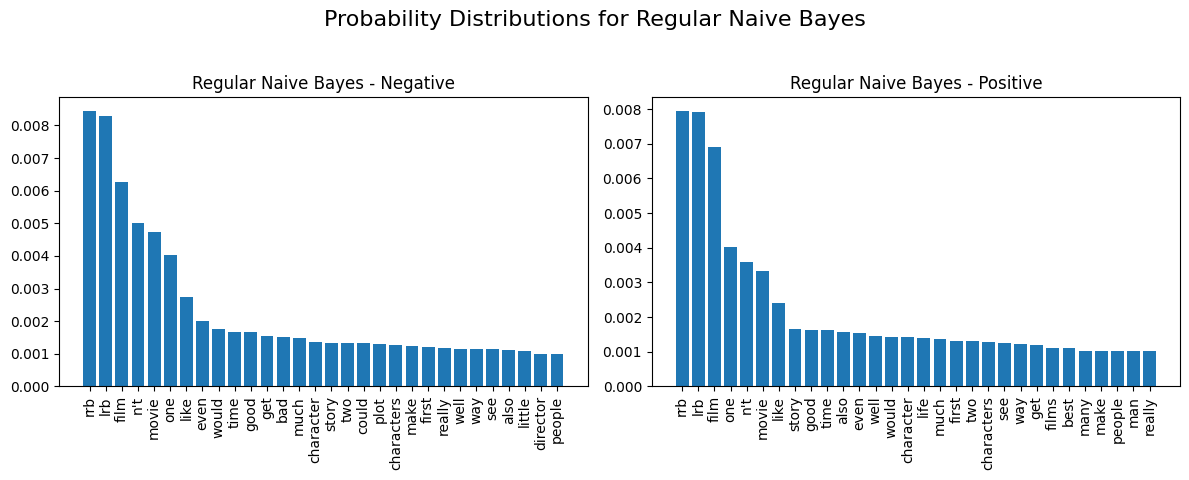

Tokens unique to class Negative: {'little', 'director', 'plot', 'bad', 'could'}
Tokens unique to class Positive: {'man', 'films', 'life', 'many', 'best'}


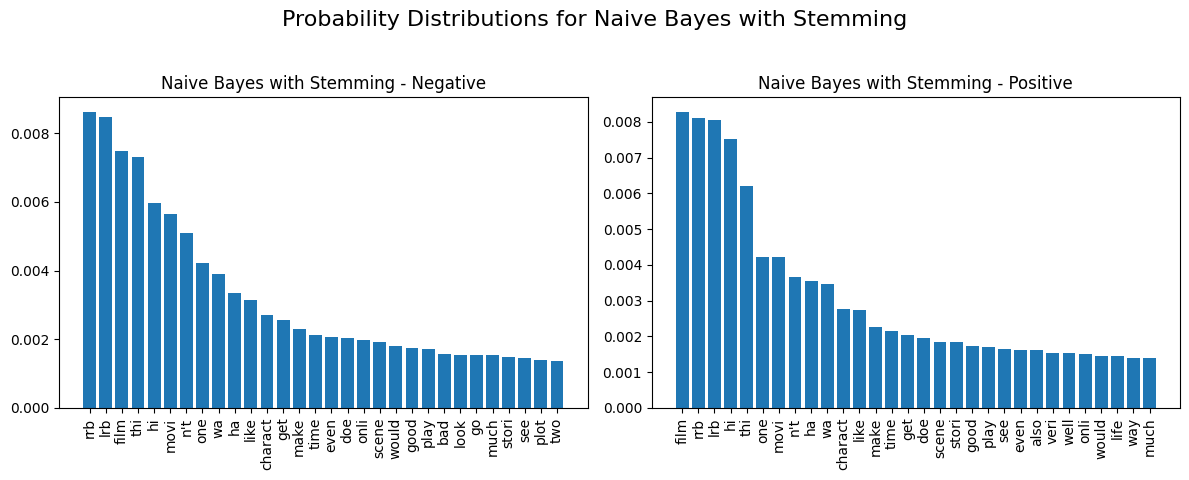

Tokens unique to class Negative: {'plot', 'bad', 'go', 'look', 'two'}
Tokens unique to class Positive: {'veri', 'way', 'well', 'life', 'also'}


In [32]:
plot_prob_distributions(nb_regular, "Regular Naive Bayes")
plot_prob_distributions(nb_stemming, "Naive Bayes with Stemming")

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [33]:
# YOUR CODE HERE
model_no_stemming = NaiveBayes()
model_no_stemming.fit(train_x, train_y, smoothing_k=1.0, stem=False)
model_stemming = NaiveBayes()
model_stemming.fit(train_x, train_y, smoothing_k=1.0, stem=True)

print(f"Size of vocab without stemming: {len(model_no_stemming._vocab.keys())}")
print(f"Size of vocab with stemming: {len(model_stemming._vocab.keys())}")

Size of vocab without stemming: 38497
Size of vocab with stemming: 25523


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [55]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, ngrams=1)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

nb_1_gram = nb

print("-" * 10)
print("Mean accuracy: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 77.0
1-fold accuracy: 83.0
2-fold accuracy: 84.0
3-fold accuracy: 82.0
4-fold accuracy: 80.5
5-fold accuracy: 82.0
6-fold accuracy: 82.5
7-fold accuracy: 82.5
8-fold accuracy: 75.0
9-fold accuracy: 84.0
----------
Mean accuracy: 0.81


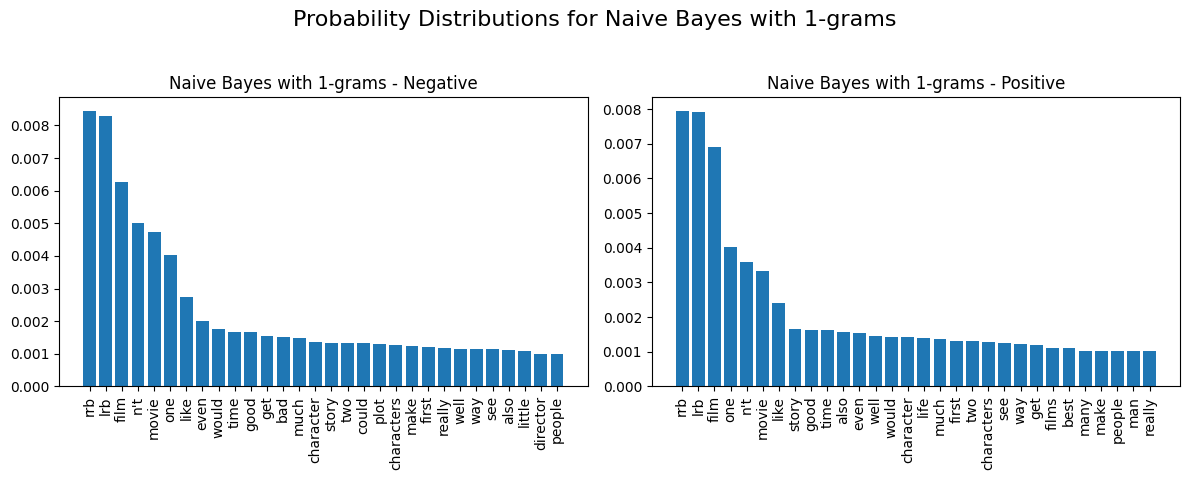

Tokens unique to class Negative: {'little', 'director', 'plot', 'bad', 'could'}
Tokens unique to class Positive: {'man', 'films', 'life', 'many', 'best'}


In [57]:
plot_prob_distributions(nb_1_gram, "Naive Bayes with 1-grams")

In [56]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, ngrams=2)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

nb_2_gram = nb

print("-" * 10)
print("Mean accuracy: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 78.5
1-fold accuracy: 85.0
2-fold accuracy: 85.5
3-fold accuracy: 86.5
4-fold accuracy: 80.5
5-fold accuracy: 82.5
6-fold accuracy: 85.0
7-fold accuracy: 82.5
8-fold accuracy: 79.5
9-fold accuracy: 83.5
----------
Mean accuracy: 0.83


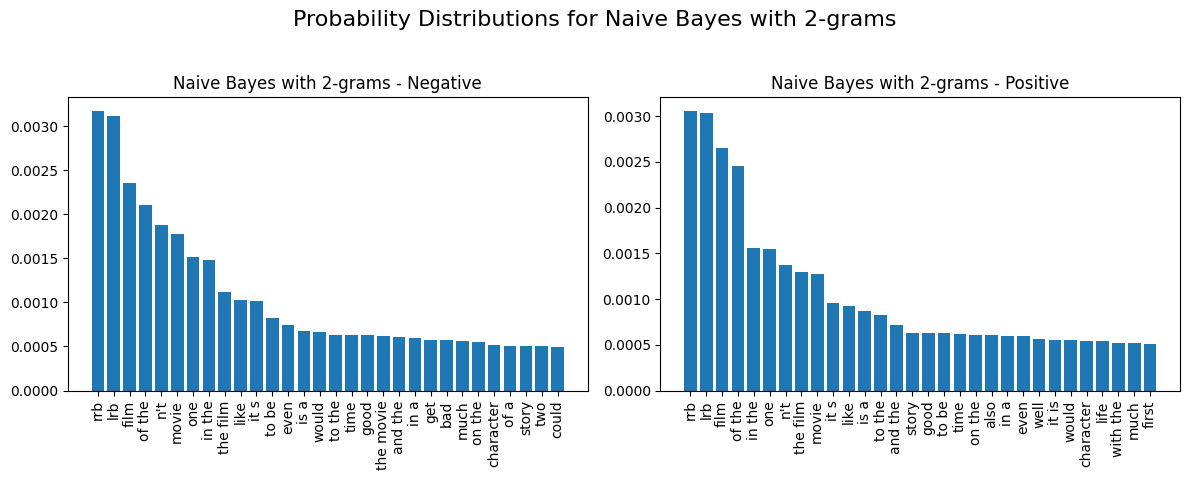

Tokens unique to class Negative: {'bad', 'could', 'of a', 'the movie', 'get', 'two'}
Tokens unique to class Positive: {'first', 'with the', 'well', 'it is', 'life', 'also'}


In [58]:
plot_prob_distributions(nb_2_gram, "Naive Bayes with 2-grams")

In [59]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, ngrams=3)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")


nb_3_gram = nb

print("-" * 10)
print("Mean accuracy: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 80.0
1-fold accuracy: 85.0
2-fold accuracy: 86.0
3-fold accuracy: 86.0
4-fold accuracy: 80.0
5-fold accuracy: 82.0
6-fold accuracy: 83.0
7-fold accuracy: 86.0
8-fold accuracy: 79.0
9-fold accuracy: 82.5
----------
Mean accuracy: 0.83


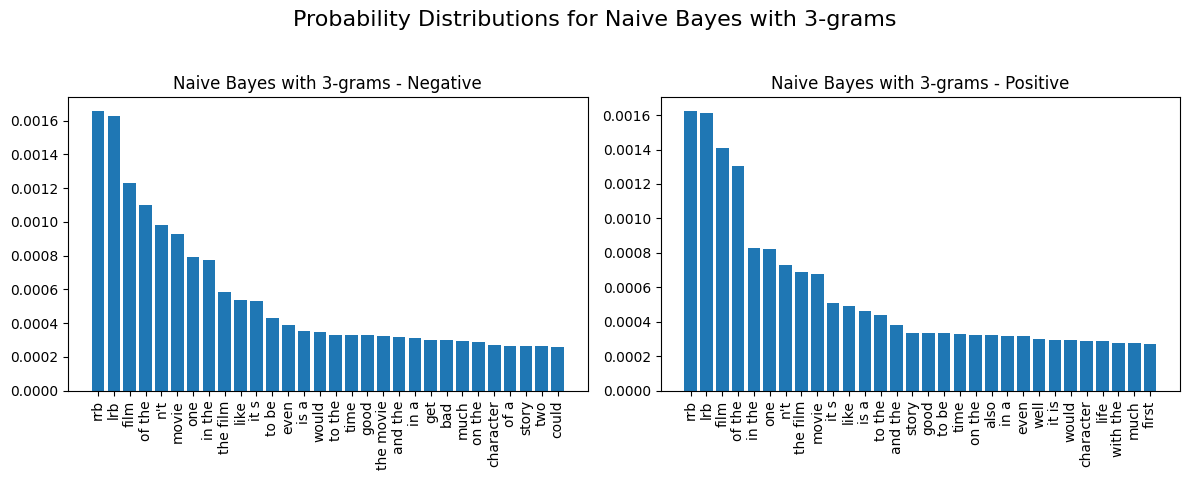

Tokens unique to class Negative: {'bad', 'could', 'of a', 'the movie', 'get', 'two'}
Tokens unique to class Positive: {'first', 'with the', 'well', 'it is', 'life', 'also'}


In [60]:
plot_prob_distributions(nb_3_gram, "Naive Bayes with 3-grams")


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [61]:
print(f"Size of vocab without stemming: {len(model_no_stemming._vocab.keys())}")
print(f"Size of vocab with stemming: {len(model_stemming._vocab.keys())}")
print(f"Size of vocab unigrams+bigrams: {len(nb_2_gram._vocab.keys())}")
print(f"Size of vocab unigrams+bigrams+trigrams: {len(nb_3_gram._vocab.keys())}")

Size of vocab without stemming: 38497
Size of vocab with stemming: 25523
Size of vocab unigrams+bigrams: 486717
Size of vocab unigrams+bigrams+trigrams: 1409923


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [128]:
dataset = Dataset(reviews)

In [129]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100)
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of Naive Bayes: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 77.0
1-fold accuracy: 83.0
2-fold accuracy: 84.0
3-fold accuracy: 82.0
4-fold accuracy: 80.5
5-fold accuracy: 82.0
6-fold accuracy: 82.5
7-fold accuracy: 82.5
8-fold accuracy: 75.0
9-fold accuracy: 84.0
----------
Mean accuracy of Naive Bayes: 0.81


In [130]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100), add_pos=True
    )
    svm = Pipeline([("cv", TfidfVectorizer()), ("svm", SVC())])

    svm.fit(x_train, y_train)
    results = svm.predict(x_test)
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of SVM: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 81.0
1-fold accuracy: 80.5
2-fold accuracy: 80.0
3-fold accuracy: 82.5
4-fold accuracy: 80.0
5-fold accuracy: 81.0
6-fold accuracy: 83.0
7-fold accuracy: 76.5
8-fold accuracy: 81.0
9-fold accuracy: 82.5
----------
Mean accuracy of SVM: 0.81


In [131]:
print("Vocab size of Naive Bayes: %d" % len(nb._vocab.keys()))
print("Vocab size of SVM: %d" % len(svm[0].vocabulary_))

Vocab size of Naive Bayes: 38497
Vocab size of SVM: 38449


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).

#### (Q3.2)
Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [118]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100), add_pos=True
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, pos_tokens=True)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of Naive Bayes: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 78.5
1-fold accuracy: 84.0
2-fold accuracy: 84.0
3-fold accuracy: 84.0
4-fold accuracy: 81.5
5-fold accuracy: 83.0
6-fold accuracy: 83.0
7-fold accuracy: 82.0
8-fold accuracy: 77.0
9-fold accuracy: 83.0
----------
Mean accuracy of Naive Bayes: 0.82


In [119]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100), add_pos=True
    )
    svm = Pipeline(
        [
            ("cv", CountVectorizer(tokenizer=lambda x: x.split(), lowercase=True)),
            ("svm", SVC()),
        ]
    )

    svm.fit(x_train, y_train)
    results = svm.predict(x_test)
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of SVM: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 72.5
1-fold accuracy: 74.5
2-fold accuracy: 69.0
3-fold accuracy: 74.5
4-fold accuracy: 73.0
5-fold accuracy: 75.0
6-fold accuracy: 80.5
7-fold accuracy: 69.0
8-fold accuracy: 76.5
9-fold accuracy: 70.5
----------
Mean accuracy of SVM: 0.73


Let's check the size of SVM's vocabulary so we could compare it later on:

In [121]:
print("Vocab size: %d" % len(svm[0].vocabulary_))

Vocab size: 54559


#### (Q3.3)
Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [122]:
IMPORTANT_POS = [
    "NN",
    "NNS",
    "NNP",
    "NNPS",
    "VB",
    "VBD",
    "VBG",
    "VBN",
    "VBP",
    "VBZ",
    "JJ",
    "JJR",
    "JJS",
    "RB",
    "RBR",
    "RBS",
]
dataset = Dataset(reviews, pos_to_keep=IMPORTANT_POS)

In [123]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100), add_pos=True
    )
    nb = NaiveBayes()
    nb.fit(x_train, y_train, smoothing_k=1.0, pos_tokens=True)
    results = [nb.predict(x) for x in x_test]
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of Naive Bayes: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 76.5
1-fold accuracy: 84.5
2-fold accuracy: 83.5
3-fold accuracy: 84.5
4-fold accuracy: 80.5
5-fold accuracy: 83.5
6-fold accuracy: 81.0
7-fold accuracy: 83.5
8-fold accuracy: 76.5
9-fold accuracy: 83.0
----------
Mean accuracy of Naive Bayes: 0.82


In [124]:
accuracies: List[float] = []

for fold in range(0, 10):
    x_train, y_train, x_test, y_test = dataset.train_test_split(
        (fold * 100, fold * 100 + 100), add_pos=True
    )
    svm = Pipeline(
        [
            ("cv", CountVectorizer(tokenizer=lambda x: x.split(), lowercase=True)),
            ("svm", SVC()),
        ]
    )

    svm.fit(x_train, y_train)
    results = svm.predict(x_test)
    accuracies.append(accuracy_score(y_test, results))

for fold, accuracy in enumerate(accuracies):
    print(f"{fold}-fold accuracy: {accuracy * 100}")

print("-" * 10)
print("Mean accuracy of SVM: %0.2f" % (sum(accuracies) / len(accuracies)))

0-fold accuracy: 79.0
1-fold accuracy: 77.5
2-fold accuracy: 77.5
3-fold accuracy: 86.0
4-fold accuracy: 80.5
5-fold accuracy: 81.0
6-fold accuracy: 83.5
7-fold accuracy: 80.5
8-fold accuracy: 81.5
9-fold accuracy: 84.0
----------
Mean accuracy of SVM: 0.81


Let's check the size of SVM's vocabulary once again:

In [126]:
print("Vocab size: %d" % len(svm[0].vocabulary_))

Vocab size: 53502


# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.